# Проект: классификация

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

- deposit.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### 1. Поиск пропущенных значений

In [188]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [189]:
# исследуем данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()
display(f"Количество пропущенных значений в признаке 'balance': {df['balance'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


"Количество пропущенных значений в признаке 'balance': 25"

### 2. Поиск неявных пропусков.

In [190]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
value_counts_job = df['job'].value_counts(dropna=False)
display(value_counts_job)
value_counts_edu = df['education'].value_counts(dropna=False)
display(value_counts_edu)

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.

Признак balance: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработайте данные этого признака так, чтобы он был преобразован в тип float.

### 3. Преобразованние в корректный вид признака balance.

In [191]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

# Удаление пробелов и знака доллара 
df['balance'] = df['balance'].replace('[\s$]', '', regex=True) 
# Замена запятой на точку и преобразование в float 
df['balance'] = df['balance'].str.replace(',', '.').astype(float)
# Вычисление среднего значения
mean_balance = df['balance'].mean()
mean_balance_rounded = round(mean_balance, 3)

print(f"Среднее значение по признаку 'balance': {mean_balance_rounded}")

Среднее значение по признаку 'balance': 1529.129


Итак, значения в признаке balance приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: заменим пропуски на медианное значение по этому признаку.

### 4. Заполнение пропусков по признаку balance.

In [192]:
# Обработаем пропуски в признаке balance, заменив их на медианные значения по данному признаку
median_balance = df['balance'].median()
df['balance'] = df['balance'].fillna(median_balance)
# Вычисление среднего значения
mean_balance = df['balance'].mean()
mean_balance_rounded = round(mean_balance, 3)

print(f"Среднее значение по признаку 'balance': {mean_balance_rounded}")


Среднее значение по признаку 'balance': 1526.936


Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Заменим все пропущенные значения в признаке job и education на модальные. То же самое сделайте с признаком, отвечающим за уровень образования.

### 5. Заменяем пропуски в job и education

In [193]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения

# Заменим значения 'unknown' на модальные значения
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])

# Найдём самую популярную работу и самый популярный уровень образования
most_popular_job = df['job'].mode()[0]
most_popular_education = df['education'].mode()[0]

# Отфильтруем клиентов с самой популярной работой и уровнем образования
filtered_df = df[(df['job'] == most_popular_job) & (df['education'] == most_popular_education)]

# Рассчитаем средний баланс для этих клиентов
mean_balance = filtered_df['balance'].mean()
mean_balance_rounded = round(mean_balance, 3)

print(f"Средний баланс для клиентов с самой популярной работой и уровнем образования: {mean_balance_rounded}")

Средний баланс для клиентов с самой популярной работой и уровнем образования: 1598.883


### 6. Изучим признак, отображающий баланс клиентов, на предмет выбросов.

Для обработки одного числового признака достаточно хорошо подходит метод Тьюки

In [194]:
# Шаг 1: Вычислить первый и третий квартиль с помощью np.percentile 
Q1 = np.percentile(df['balance'], 25) 
Q3 = np.percentile(df['balance'], 75)

# Шаг 2: Вычислить межквартильный размах (IQR)
IQR = Q3 - Q1

# Шаг 3: Определить нижнюю и верхнюю границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Округлим границы до целых чисел
lower_bound_rounded = round(lower_bound)
upper_bound_rounded = round(upper_bound)

print(f"Нижняя граница: {lower_bound_rounded}")
print(f"Верхняя граница: {upper_bound_rounded}")

# Анализ выбросов меодом Тьюки (строгое неравенство)
#df_nb = df[(df['balance'] > lower_bound) & (df['balance'] < upper_bound)]

# Анализ выбросов меодом Тьюки (нестрогое неравенство)
df_nb = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
df_nb.shape

Нижняя граница: -2241
Верхняя граница: 4063


(10105, 17)

## Часть 2:  Разведывательный анализ
В данной части проекта вам необходимо будет:

- исследовать данные;
- попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;
- дополнить анализ визуализациями, иллюстрирующими ваше исследование.

### 1. Изучим распределение целевой переменной
Есть ли несбалансированность классов? Чтобы это определить, вычислим частоты для открывших депозит и для тех, кто его не открыл.

deposit
no     5424
yes    4681
Name: count, dtype: int64


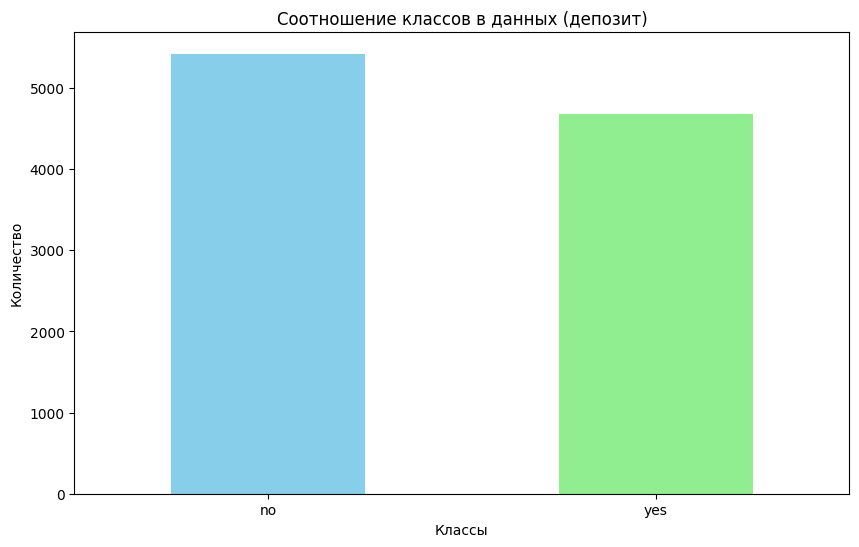

Частота для открывших депозит: 4681
Частота для не открывших депозит: 5424
Классы несбалансированы


In [195]:
# изучим соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

# Подсчет количества значений для каждого класса (открывших депозит и не открывших)
class_counts = df_nb['deposit'].value_counts()
print(class_counts)
# Вычисление частот для открывших депозит и тех, кто его не открыл
yes_count = class_counts.get('yes', 0)
no_count = class_counts.get('no', 0)
# Построение гистограммы
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Соотношение классов в данных (депозит)')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

print(f"Частота для открывших депозит: {yes_count}")
print(f"Частота для не открывших депозит: {no_count}")

# Определение несбалансированности классов
if yes_count != no_count:
    print("Классы несбалансированы")
else:
    print("Классы сбалансированы")


### 2. Описательные статистик для количественных переменных

In [196]:
#рассчитаем описательные статистики для количественных переменных, проинтерпретируйте результат
descriptive_stats = df_nb.describe()
display(descriptive_stats)


,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### 3. Теперь давайте рассмотрим описательные статистики для категориальных переменных.

Попробуем извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

In [197]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
descriptive_object_stats = df_nb.describe(include = 'object')
print(descriptive_object_stats)
#постройте визуализации, иллюстрирующие результаты

               job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424  


Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

### 6. Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008


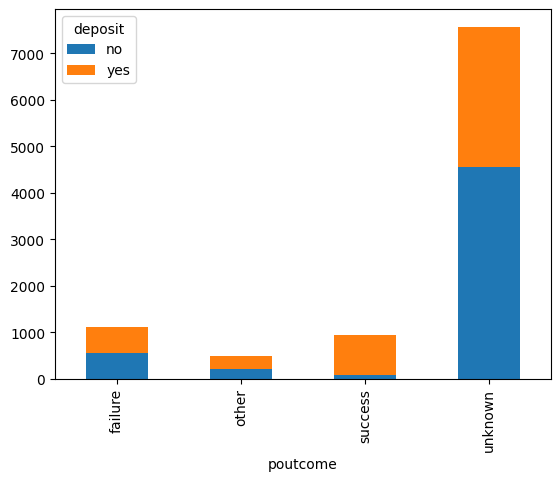

In [198]:

# Сгруппируем данные по признаку предыдущей кампании (poutcome) и применим метод value_counts()
types = df_nb.groupby('poutcome')['deposit'].value_counts().unstack(fill_value=0)
types.plot(kind='bar', stacked='True')
# Выведем результат
print(types)


Теперь давайте узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

### 7. В каком месяце чаще всего отказывались от предложения открыть депозит

In [199]:
# Подсчет количества отказов (response == 'no') по месяцам
refusal_counts = df_nb[df_nb['deposit'] == 'no']['month'].value_counts()
display(refusal_counts)
# Определение месяца с наибольшим количеством отказов
most_refusal_month = refusal_counts.idxmax()
most_refusal_count = refusal_counts.max()

print(f"Месяц с наибольшим количеством отказов: {most_refusal_month} ({most_refusal_count} отказов)")


month
may    1776
jul     836
aug     775
jun     606
nov     456
feb     323
apr     317
jan     194
oct      62
sep      46
mar      24
dec       9
Name: count, dtype: int64

Месяц с наибольшим количеством отказов: may (1776 отказов)


Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

### 8. Создадим возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

In [200]:
# Создание новой переменной 'age_group' с возрастными категориями
df_nb['age_group'] = pd.cut(df_nb.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
df_nb.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


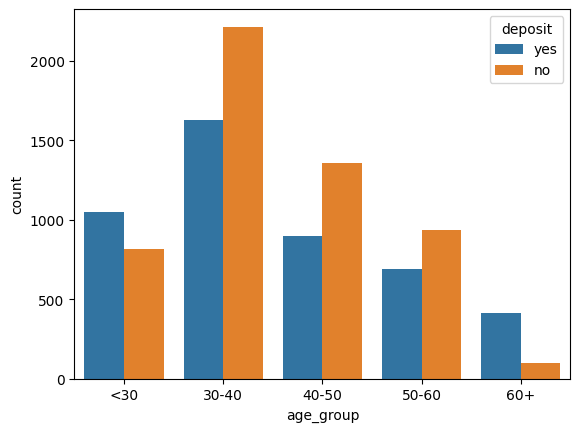

In [201]:
sns.countplot(x="age_group", hue="deposit", data=df_nb);


Вывод: Клиенты до 30 и старше 60 более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

- семейное положение;
- уровень образования;
- сфера занятости.

9. Построим визуализации, отражающие количество тех, кто открыл депозит, и тех, кто - его не открыл, для всех категорий предложенных выше трёх признаков. Постарайтесь оформить диаграммы максимально наглядно и описать полученный результат.

<Axes: xlabel='count', ylabel='marital'>

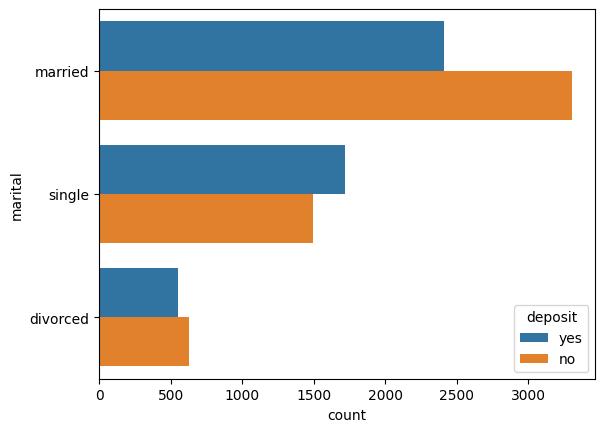

In [202]:
# Используем countplot() из библиотеки seaborn

sns.countplot(y='marital', hue='deposit', data=df_nb)
# 

Вывод: одинокие люди чаще открывают депозит

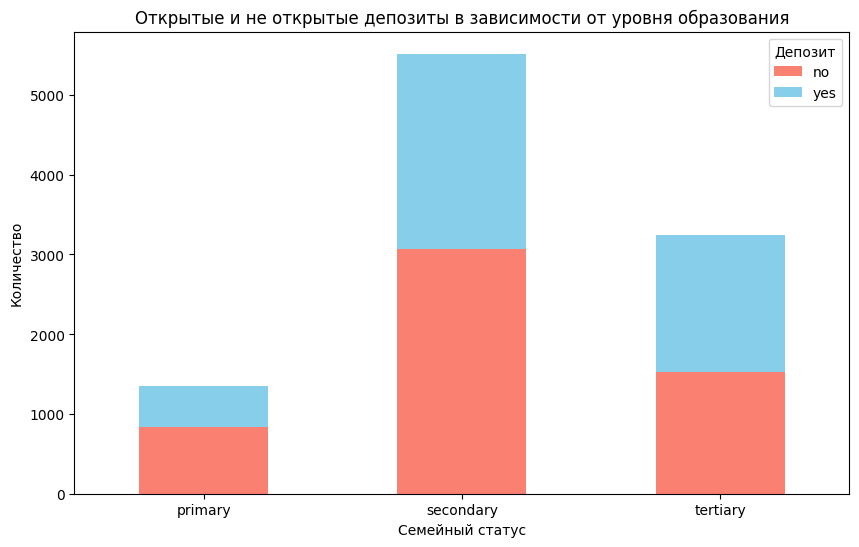

In [203]:
# Группировка данных по образованию и статусу депозита
edu_deposit_counts = df_nb.groupby(['education', 'deposit']).size().unstack(fill_value=0)

# Построение диаграммы
edu_deposit_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'skyblue'])
plt.title('Открытые и не открытые депозиты в зависимости от уровня образования')
plt.xlabel('Семейный статус')
plt.ylabel('Количество')
plt.legend(title='Депозит')
plt.xticks(rotation=0)
plt.show()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

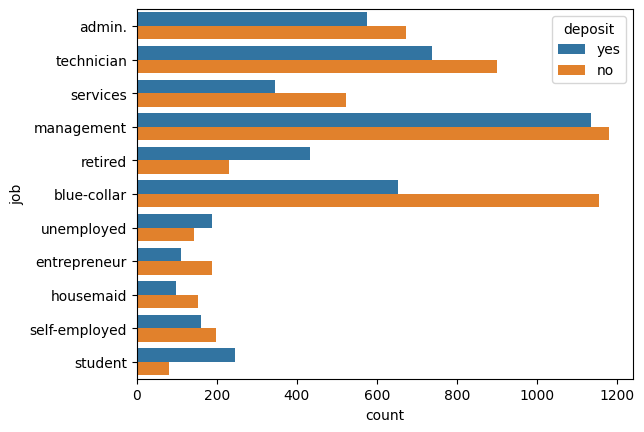

In [204]:
# Используем countplot() из библиотеки seaborn

sns.countplot(y='job', hue='deposit', data=df_nb)

display(df_nb['job'].value_counts())

### 11. Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

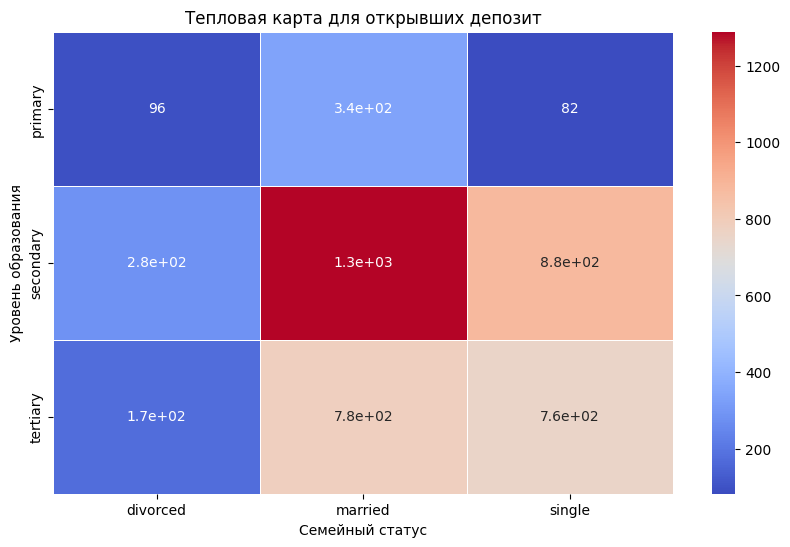

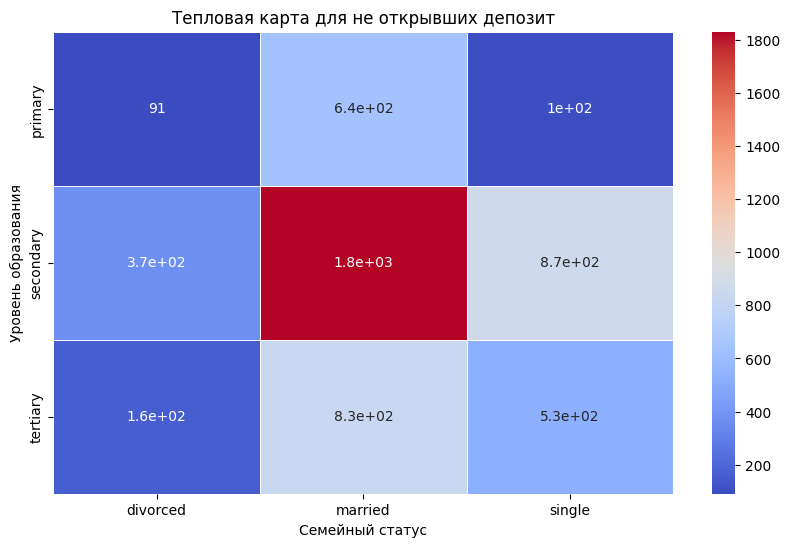

In [205]:
# Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл
df_yes = df_nb[df_nb['deposit'] == 'yes']
df_no = df_nb[df_nb['deposit'] == 'no']

# Построим сводные таблицы по уровню образования и семейному положению для обеих групп
crosstab_yes = pd.crosstab(df_yes['education'], df_yes['marital'])
crosstab_no = pd.crosstab(df_no['education'], df_no['marital'])

# Построим тепловую карту для тех, кто открыл депозит
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_yes, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Тепловая карта для открывших депозит')
plt.xlabel('Семейный статус')
plt.ylabel('Уровень образования')
plt.show()

# Построим тепловую карту для тех, кто не открыл депозит
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_no, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Тепловая карта для не открывших депозит')
plt.xlabel('Семейный статус')
plt.ylabel('Уровень образования')
plt.show()



## Часть 3: преобразование данных

Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.

Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.
Надо отобрать признаки, которые мы будем использовать для обучения модели.

### 1. Начнём с обработки категориального порядкового признака
- Который отвечает за уровень образования: education.
- Ранее мы создали порядковую переменную для возраста. Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [206]:
# создадим копию таблицы
df_end = df_nb.copy()
# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

# Применяем LabelEncoder к признаку education
df_end['education'] = label_encoder.fit_transform(df_end['education'])
# Применяем LabelEncoder к признаку age
df_end['age_group'] = label_encoder.fit_transform(df_end['age_group'])

display(df_end.head())
edu_sum = df_end['education'].sum()
print(f'Сумма получившихся значений education: {edu_sum}')



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


Сумма получившихся значений education: 11995


### 2. Продолжим преобразовывать теперь бинарные признаки

- Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.
- Сделаем то же самое для других бинарных переменных, которых у нас три:
- 'default';
- 'housing';
- 'loan'.

Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [207]:
# преобразуем бинарные переменные в представление из нулей и единиц

# Применяем метод замены значений для перекодирования переменных
df_end['deposit'] = df_end['deposit'].map({'yes': 1, 'no': 0})
df_end['default'] = df_end['default'].map({'yes': 1, 'no': 0})
df_end['housing'] = df_end['housing'].map({'yes': 1, 'no': 0})
df_end['loan'] = df_end['loan'].map({'yes': 1, 'no': 0})

# демонстрация промежутиочного датасета
display(df_end.head())

# Вычисление стандартного отклонения для целевой переменной deposit
deposit_std = df_end['deposit'].std()
print(f'Стандартное отклонение для переменной deposit: {round(deposit_std, 3)}')

# среднее арифметическое для каждой из получившихся переменных
sum_of_mean = df_end['default'].mean() + df_end['housing'].mean() + df_end['loan'].mean()
print(f'Сумма получившихся значений education_encoded: {round(sum_of_mean, 3)}')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


Стандартное отклонение для переменной deposit: 0.499
Сумма получившихся значений education_encoded: 0.635


### 4. Теперь нам необходимо преобразовать номинальные переменные, Это следующие переменные:

- 'job';
- 'marital';
- 'contact';
- 'month';
- 'poutcome'.

Создадим для них dummy-переменные и добавим их в набор данных.

In [208]:
# Создаем dummy-переменные для указанных признаков
df_dum = pd.get_dummies(df_end, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

display(df_dum.shape)

(10105, 46)

In [209]:
# Удаление столбцов 'education' и 'age'
#df_dum = df_dum.drop(columns=['education', 'age_group', 'age'])

df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### 5. Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

- Пострим матрицу корреляций. Дополним её тепловой картой, отражающей результат.

- В качестве дополнения визуализации построим столбчатую диаграмму для ранжированных коэффициентов корреляции.

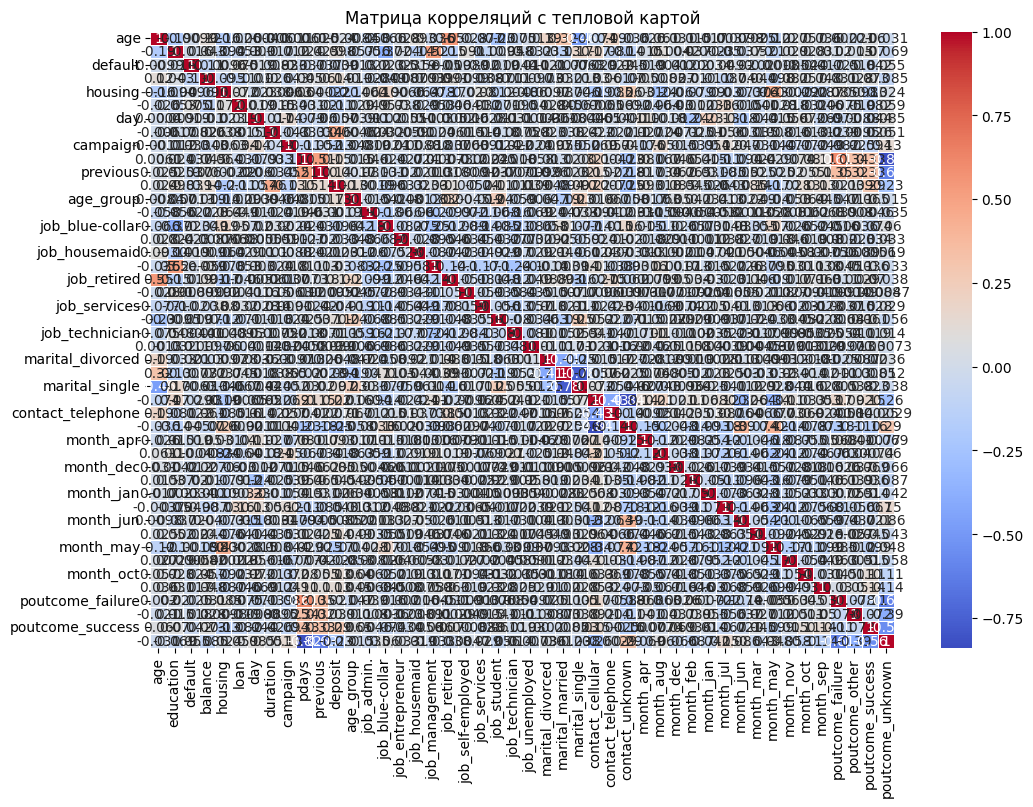

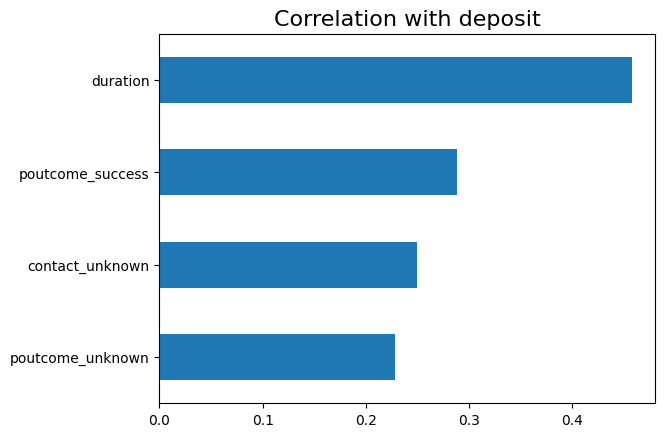

In [210]:
# Построение матрицы корреляций
corr_matrix = df_dum.corr()

# Построение тепловой карты корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Матрица корреляций с тепловой картой')
plt.show()

corr_matrix["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

Вывод: наиболее корелирующе с целевой переменной признаки: duration & pouycome_sucsess

### 7. Разделение выборки

- Необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

- Зададим параметр random_state = 42, а размер тестовой выборки 0.33. Добавим аргумент, определяющий сохранение соотношений целевого признака.

In [211]:
X = df_dum.drop(['deposit'], axis=1)
y = df_dum['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [212]:
# размер тестовой выборки
print(f'Размер тестовой выборки: {X_test.shape[0]}')
# Вычисление среднего значения целевой переменной на тестовой выборке
mean_deposit = y_test.mean()
print(f'Среднее значение целевой переменной на тестовой выборке: {round(mean_deposit, 2)}')
display(X_train)

Размер тестовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке: 0.46


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
7287,34,2,0,557.0,1,0,16,513,1,-1,...,False,False,False,False,False,False,False,False,False,True
4766,34,2,0,69.0,0,1,25,296,1,205,...,False,False,False,True,False,False,True,False,False,False
5712,33,2,0,0.0,1,0,5,399,2,358,...,False,False,True,False,False,False,False,True,False,False
2530,37,1,0,444.0,0,0,14,137,1,102,...,False,False,False,False,False,False,False,False,True,False
9294,39,1,0,1444.0,0,0,19,100,1,117,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,30,2,0,222.0,0,1,4,111,1,204,...,False,False,False,False,False,False,False,True,False,False
1056,53,1,0,1777.0,1,0,21,796,5,154,...,False,False,False,True,False,False,True,False,False,False
2931,76,0,0,3324.0,0,0,13,122,1,92,...,False,False,False,True,False,False,False,False,True,False
7735,29,1,0,209.0,0,0,5,605,2,-1,...,False,False,False,False,False,False,False,False,False,True


### 9. Отбор признаков
- Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

- С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр score_func = f_classif.

- На данном этапе необходимо оставить только те признаки, которые содержат лишь числовые значения.

In [213]:
# Используем SelectKBest для выбора 15 лучших признаков
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_train, y_train)

# Получим выбранные признаки
selected_features = X_train.columns[selector.get_support()]

print("Выбранные признаки:", selected_features)


Выбранные признаки: Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


### 10. Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

- Нормализация требуется для предикторов, а не для целевой переменной.

In [214]:
df_norm = df_dum[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'deposit']].copy()

X = df_norm.drop(['deposit'], axis=1)
y = df_norm['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)


mmscaler = preprocessing.MinMaxScaler()
# Применяем MinMaxScaler к обучающей выборке
X_train_scaled = mmscaler.fit_transform(X_train)

# Применяем MinMaxScaler к тестовой выборке
X_test_scaled = mmscaler.transform(X_test)

print(round(X_test_scaled[:, 0].mean(), 2))  # для признака balance, обратите внимание именно на столбец

0.47


## Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### 1. Логистическая регрессия. 

В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

- Оценим качество модели на тестовой выборке.

- Для получившейся модели вычислим значение accuracy на тестовой выборке.

In [215]:
# создаем обькт модели
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )
# обучение модели
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)

# Вычисляем F1-score для тренировочной выборки
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(y_train, y_train_pred)
print("accuracy train:", accuracy_train)
# Вычисляем F1-score для тестовой выборки
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Значение точности на тестовой выборке: {accuracy_test:.2f}')

accuracy train: 0.823781388478582
Значение точности на тестовой выборке: 0.81


### 2. Решающие деревья. 

В качестве параметров для начала возьмём следующие:

- criterion = 'entropy';
- random_state = 42.

Остальные параметры оставим по умолчанию.

In [216]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_unlim = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

#Обучаем дерево решений по алгоритму CART
dt_clf_unlim.fit(X_train_scaled, y_train)

#Делаем предсказание класса:
y_train_pred = dt_clf_unlim.predict(X_train_scaled)
y_test_pred = dt_clf_unlim.predict(X_test_scaled)

#Выводим значения метрики 
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Значение точности на тренировочной выборке: {accuracy_train:.2f}')
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Значение точности на тестовой выборке: {accuracy_test:.2f}')

Значение точности на тренировочной выборке: 0.82
Значение точности на тестовой выборке: 0.81


### 5. Подбор гперпараметров

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуем оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

- 'min_samples_split': [2, 5, 7, 10];
- 'max_depth':[3,5,7].

In [217]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Определяем параметры для GridSearch
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3, 5, 7]}

# Создаем объект класса DecisionTreeClassifier
dt_clf_find = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=dt_clf_find, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='f1', 
                           return_train_score=True)

# Обучаем GridSearch на обучающих данных
grid_search.fit(X_train_scaled, y_train)

# Выводим лучшие параметры и наилучшее значение точности
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Лучшие параметры: {best_params}')
print(f'Наилучшее значение точности: {best_score:.2f}')


Лучшие параметры: {'max_depth': 7, 'min_samples_split': 7}
Наилучшее значение точности: 0.80


In [218]:
from sklearn.metrics import f1_score
#Создаём объект класса DecisionTreeClassifier
dt_clf_best = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    min_samples_split=7,
    max_depth=7
)

#Обучаем дерево решений по алгоритму CART
dt_clf_best.fit(X_train_scaled, y_train)

#Делаем предсказание класса:
y_train_pred = dt_clf_best.predict(X_train_scaled)
y_test_pred = dt_clf_best.predict(X_test_scaled)

#Выводим значения метрики 
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Значение точности на тренировочной выборке: {accuracy_train:.2f}')
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Значение точности на тестовой выборке: {accuracy_test:.2f}')
f1_test = f1_score(y_test, y_test_pred)
print(f'Значение f1_score на тестовой выборке: {f1_test:.2f}')

Значение точности на тренировочной выборке: 0.84
Значение точности на тестовой выборке: 0.81
Значение f1_score на тестовой выборке: 0.80


## Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### 1. Случайный лес со следующими параметрами:

- n_estimators = 100;
- criterion = 'gini';
- min_samples_leaf = 5;
- max_depth = 10;
- random_state = 42.

In [219]:
#Создаём объект класса случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf = 5,
    max_depth=10, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train_scaled, y_train)

#Делаем предсказание класса:
y_train_pred = rf_clf.predict(X_train_scaled)
y_test_pred = rf_clf.predict(X_test_scaled)

#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### 2. Градиентный бустинг
Параметры:

learning_rate = 0.05;
n_estimators = 300;
min_samples_leaf = 5;
max_depth = 5;
random_state = 42.

In [220]:
# Создаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

#Обучаем модель 
gb.fit(X_train_scaled, y_train)

#Делаем предсказание класса:
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Вывод: на имеюихся данных луше работает случайный лес

### 4. Стекинг

Объединим те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

In [221]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

# Создаем объект класса стекинг
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

# Обучаем модель
stack.fit(X_train_scaled, y_train)

#Делаем предсказание класса:
y_train_pred = stack.predict(X_train_scaled)
y_test_pred = stack.predict(X_test_scaled)

#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### 5. Выберем три признака, дающих наибольший вклад

In [222]:
# Оценка важности признаков
feature_importances = gb.feature_importances_

# Создаем DataFrame для важностей признаков, используя имена столбцов из X_train
features_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

# Сортируем признаки по важности в порядке убывания
features_df = features_df.sort_values(by='importance', ascending=False)

# Выводим три наиболее значимых признака
features_df.head(3)

,feature,importance
2,duration,0.507106
13,poutcome_success,0.114958
8,contact_unknown,0.072582


### 6. фреймворк Optuna
возьмем случайный лес и следующие параметры:

- n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
- max_depth = trial.suggest_int('max_depth', 10, 30, 1);
- min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [223]:
# Устанавливаем библиотеку
#!pip install optuna

import optuna
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 4.0.0


In [224]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем и обучаем модель
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_clf.fit(X_train_scaled, y_train)

    # Делаем предсказания
    y_pred = rf_clf.predict(X_train_scaled)

    # Вычисляем метрики
    f1 = f1_score(y_train, y_pred)
    acc = accuracy_score(y_train, y_pred)

    return f1, acc

# Создаем объект study для многокритериальной оптимизации
study = optuna.create_study(study_name="RandomForestClassifier", directions=["maximize", "maximize"])
study.optimize(optuna_rf, n_trials=20)

# Получаем лучшие значения гиперпараметров и метрик
best_trial = study.best_trials[0]  # Для многокритериальной оптимизации используем best_trials
best_params = best_trial.params
best_f1 = best_trial.values[0]
best_acc = best_trial.values[1]

# выводим результаты на обучающей выборке
print(f'Лучшие параметры: {best_params}')
print(f'Наилучшее значение F1-Score: {best_f1:.2f}')
print(f'Наилучшее значение Accuracy: {best_acc:.2f}')


[I 2025-01-17 16:42:09,842] A new study created in memory with name: RandomForestClassifier
[I 2025-01-17 16:42:10,540] Trial 0 finished with values: [0.8458522816371334, 0.8548005908419498] and parameters: {'n_estimators': 193, 'max_depth': 26, 'min_samples_leaf': 10}.
[I 2025-01-17 16:42:11,257] Trial 1 finished with values: [0.8509773260359657, 0.859231905465288] and parameters: {'n_estimators': 196, 'max_depth': 20, 'min_samples_leaf': 9}.
[I 2025-01-17 16:42:11,784] Trial 2 finished with values: [0.853125, 0.8611521418020679] and parameters: {'n_estimators': 137, 'max_depth': 22, 'min_samples_leaf': 8}.
[I 2025-01-17 16:42:12,272] Trial 3 finished with values: [0.9102927289896129, 0.9158050221565731] and parameters: {'n_estimators': 102, 'max_depth': 18, 'min_samples_leaf': 2}.
[I 2025-01-17 16:42:13,010] Trial 4 finished with values: [0.8537080405932865, 0.8615952732644018] and parameters: {'n_estimators': 197, 'max_depth': 16, 'min_samples_leaf': 8}.
[I 2025-01-17 16:42:13,506] 

Лучшие параметры: {'n_estimators': 107, 'max_depth': 29, 'min_samples_leaf': 2}
Наилучшее значение F1-Score: 0.92
Наилучшее значение Accuracy: 0.93


In [225]:
# Метрики на тестовой выборке с лушими параметрами
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=147, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf = 3,
    max_depth=29, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train_scaled, y_train)

#Делаем предсказание класса:
y_test_pred = rf_clf.predict(X_test_scaled)

#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

